### Randomized Search Cross Validation

많은 수의 parameter를 가진 Machine Learning Algorithm의 경우, Grid Search Cross Validation은 감당할 수 없는 계산량이 소요된다. 이 경우에 좋은 통계적 성질을 가진 대안은 각 parameter를 분포로부터 추출하는 것이다. 이 방법에는 두 가지 장점이 있다. 첫째, 문제이 차원에 상관없이 검색하고자 하는 조합의 개수를 통제할 수 있다. 둘째, 상대적으로 성과와 무관한 parameter를 가지고 있더라도 `GridSearchCV`의 경우처럼 검색 시간이 크게 늘지 않는다. 아래의 코드는 `RandomizedSearchCV`에 sample weights를 고려하도록 설계된 것이다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

testing = False
n_samples = 1000
n_splits = 3

trnsX, cont = get_test_data(
    n_features = 20,
    n_informative = 10,
    n_redundant = 5,
    n_samples = n_samples,
)

In [3]:
cont.head()

,bin,w,t1
2021-11-15 23:19:22.586201,0,0.001,2021-11-15 23:19:22.586201
2021-11-16 23:19:22.586201,0,0.001,2021-11-16 23:19:22.586201
2021-11-17 23:19:22.586201,0,0.001,2021-11-17 23:19:22.586201
2021-11-18 23:19:22.586201,0,0.001,2021-11-18 23:19:22.586201
2021-11-19 23:19:22.586201,0,0.001,2021-11-19 23:19:22.586201


In [4]:
from sklearn.svm import SVC
from FinancialMachineLearning.cross_validation.cross_validation import clf_hyper_fit
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    trnsX, 
    cont, 
    test_size = 0.3, 
    shuffle = False
)

In [5]:
from sklearn.ensemble import BaggingClassifier
from FinancialMachineLearning.cross_validation.cross_validation import FMLPipeline

base_estimator = SVC(
    random_state = 42, 
    probability = True
)

pipe_clf = FMLPipeline(
    [
        (
            'clf', 
            BaggingClassifier(
                estimator = base_estimator, 
                random_state = 42
            )
        )
    ]
)

param_grid = {
    'clf__n_estimators': [10, 50, 100],
    'clf__max_samples': [0.5, 0.7, 1.0],
    'clf__max_features': [0.5, 0.7, 1.0],
    'clf__estimator__C': [0.1, 1, 10],
    'clf__estimator__kernel': ['linear', 'rbf'],
}

In [6]:
samples_info_sets = y_train['t1']

fitted_model = clf_hyper_fit(
    feat = X_train,
    label = y_train['bin'],
    samples_info_sets = samples_info_sets,
    pipe_clf = pipe_clf,
    param_grid = param_grid,
    cv = 3, 
    bagging = [0, None, 1],
    random_search_iterator = 1,
    n_jobs = 8,
    pct_embargo = 0.01
)

In [7]:
fitted_model

FMLPipeline(steps=[('clf',
                    BaggingClassifier(estimator=SVC(C=1, probability=True,
                                                    random_state=42),
                                      max_samples=0.7, random_state=42))])

In [8]:
y_pred = pd.Series(
    fitted_model.predict(X_test),
    index = y_test.index
)
y_proba = pd.DataFrame(
    fitted_model.predict_proba(X_test),
    index = y_test.index,
    columns = [0, 1]
)

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test['bin'], y_pred))

              precision    recall  f1-score   support

           0       0.23      1.00      0.38        50
           1       1.00      0.35      0.52       250

    accuracy                           0.46       300
   macro avg       0.62      0.67      0.45       300
weighted avg       0.87      0.46      0.49       300



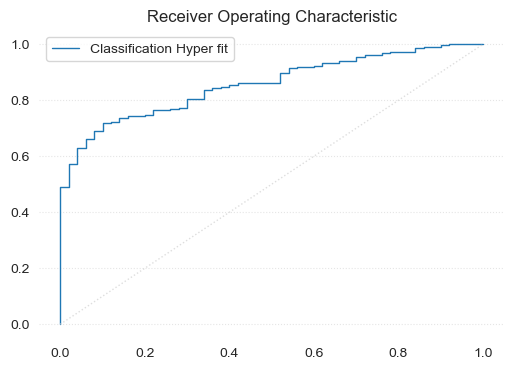

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thres = roc_curve(y_test['bin'], y_proba[1])

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr, tpr, label = 'Classification Hyper fit', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### 1. Log Uniform Distribution

일부 머신러닝 알고리즘은 흔히 음수가 아닌 Hyper Parameter만 허용한다. 이는 일부 아주 유명한 parameter에도 해당되는데, 예를 들어 `SVC` 분류기의 C나 RBF 커널의 `gamma`와 같은 경우이다. 0에서부터 적당히 큰 수, 예컨대 100정도 되는 사이에 균등 분포의 랜덤 수를 발생시킬 수 있다. 이 경우 99%의 발생된 수가 1보다 더 클 것으로 예상된다. 함수의 반응이 선형이 아닌 parameter의 실현 가능 영역을 탐색하는 데 가장 좋은 방법이 되지 못할 수 있다. 예를 들어, `SVC`에 있어 C의 반응은 0.01에서 1 사이의 증가나 1부터 100사이의 증가와 비슷할 수 있다. 그러므로, $U(0, 100)$ 분포로부터 C를 추출하는 것은 비효율적일 수 있다. 이런 경우에는 추출의 log 값이 균등한 분포로부터 값을 추출하는 것이 좀 더 효율적이다. Prado 교수는 이를 'Log Uniform Distribution'이라고 부르는데, 문헌 어디에도 해당하는 용어를 찾을 수 없다. 이제 이를 적절히 정의할 필요가 있다.

Random variable $x$는 오로지 $\log(x) \sim U[\log(a), \log(b)]$일 경우에만 $a > 0$와 $b > a$사이에서 로그 균등 분포를 따른다. 이 분포는 다음의 누적 분포 함수를 가진다.

$$F[x] = 
\begin{cases}
\frac{\log(x) - \log(a)}{\log(b) - \log(a)} &\text{ for } a \leq x \leq b \\
0 &\text{ for } x \leq a \\
1 &\text{ for } x \leq b
\end{cases}
$$

이로부터 확률 분포 함수를 도출할 수 있다.

$$
f[x] = 
\begin{cases}
\frac{1}{x\log \left[\frac{b}{a} \right]} &\text{ for } a \leq x \leq b \\
0 &\text{ for } x \leq a \\
0 &\text{ for } x \leq b
\end{cases}
$$

CDF는 로그의 및과는 무관하다는 점에 주목하자. 모든 $c$에 대해 $\frac{\log(x) - \log(a)}{\log(b) - \log(a)} = \frac{\log_c(x) - \log_c(a)}{\log_c(b) - \log_c(a)}$이므로 랜덤 변수는 $c$의 함수가 아니다. 아래의 코드는 $[a, b] = [0.001, 1000]$일 때 랜덤 변수를 `scipy.stats`에서 구현한다. 그러므로 $\log(x) \sim U[\log(0.001), \log(1000)]$이다. 아래의 그림은 log scale에서의 표본의 균등성을 보여 준다.

In [11]:
from scipy.stats import rv_continuous, kstest
from FinancialMachineLearning.cross_validation.cross_validation import log_uniform

a, b, size = 1e-3, 1e3, 1000
vals = log_uniform(a = a, b = b).rvs(size = size)
print(kstest(
    rvs = np.log(vals), 
    cdf = 'uniform', 
    args = (np.log(a), np.log(b / a)), 
    N = size
))
print(pd.Series(vals).describe())

KstestResult(statistic=0.0286421921595143, pvalue=0.3777532646024503, statistic_location=-2.477919687873558, statistic_sign=-1)
count    1000.000000
mean       72.928889
std       179.628058
min         0.001007
25%         0.039642
50%         1.181274
75%        26.806219
max       969.265847
dtype: float64


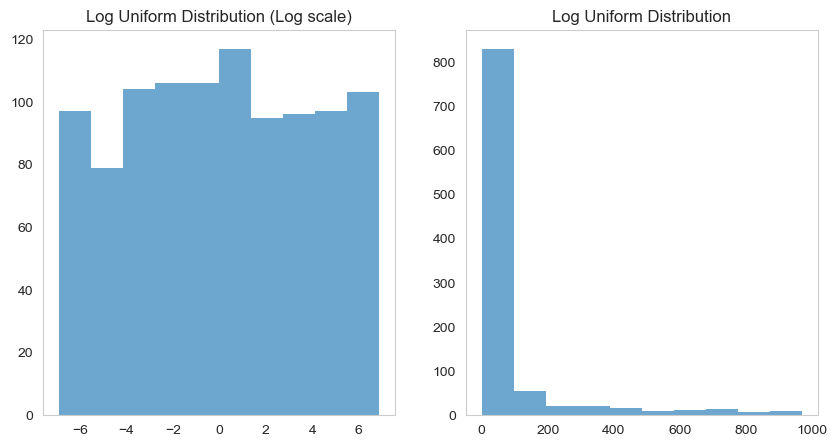

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
pd.Series(np.log(vals)).hist(
    edgecolor = 'none',
    alpha = 0.65
)
plt.grid(False)
plt.title('Log Uniform Distribution (Log scale)')

plt.subplot(122)
pd.Series(vals).hist(
    edgecolor = 'none',
    alpha = 0.65
)
plt.grid(False)
plt.title('Log Uniform Distribution')

plt.show()

### Scoring and Hyper-Parameter Tuning